In [1]:
import sys 
sys.path.append('..')
from utils import wasserstein2
from kernels import *
from distributions import *
from kernelGAN import *
import torch, matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

device = torch.device('cpu')
%matplotlib inline
plt.rcParams.update({'font.size': 20})
%load_ext autoreload
%autoreload 2

In [2]:
# distribution params
n_true, n_gen, d = 4, 8, 2
n_mixture, sigma = 4, 0.125
device = torch.device('cpu')
# initializing points
true_distr = DistrFactory().get_distr('ring', dim=d, n_mixture=n_mixture, std=0, radius=1, device=device)
X_true, y_true = true_distr.sample_n(n_true)
gen_distr = DistrFactory().get_distr('ring', dim=d, n_mixture=n_mixture, std=sigma, radius=1, device=device)
p_gen = torch.randn(n_gen).softmax(-1)
p_true = torch.randn(n_true).softmax(-1)

In [4]:
# training params
T, lr_d, lr_g, lam = 1000, 1e-1, 1e-2, 1
num_trials=3
widths = [0.1, 0.5, 1]

W_dist = np.zeros((len(widths),num_trials, T))
for j in range(num_trials):
    # reinitialize generated points
    X_gen_init, y_gen = gen_distr.sample_n(n_gen)
    G = PointGenerator(X_gen_init, p_gen)
    for i, width_param in enumerate(widths):
        # set kernel parameters
        DK = Kernel('laplacian', width_param=width_param)
        # find generated trajectories
        model = KernelGAN(G, DK, device)
        model.train(X_true, p_true, lr_d, lr_g, T, lam)
        # calculate w2 distances
        curr_w2 = wasserstein2(model.G.X_gen.detach().cpu().numpy(), X_true.detach().cpu().numpy())
        W_dist[i,j,:] = curr_w2

100%|██████████| 999/999 [00:00<00:00, 1052.20it/s]


## W2 distance over the course of training

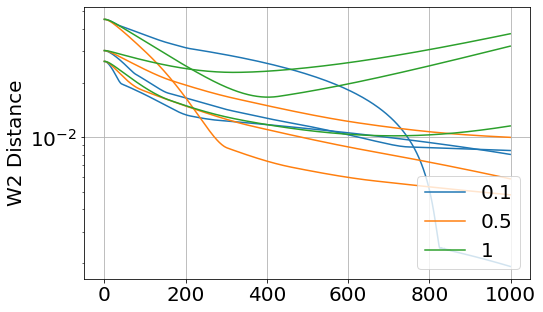

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
for i, width_param in enumerate(widths):
    for j in range(num_trials):
        if j==0:
            ax.semilogy(list(range(T)), W_dist[i,j,:], c=f'C{i}', label=f'{width_param}')
        else:
            ax.semilogy(list(range(T)), W_dist[i,j,:], c=f'C{i}')
plt.legend(loc='lower right')
plt.grid()
plt.ylabel('W2 Distance')
plt.show()

## Animation

In [10]:
# reinitialize generated points
X_gen_init, y_gen = gen_distr.sample_n(n_gen)
G=PointGenerator(X_gen_init, p_gen)
# set kernel parameters
width_param=0.25
DK = Kernel('gaussian', width_param=width_param)
# find generated trajectories
model = KernelGAN(G, DK, device)
model.train(X_true, p_true, lr_d, lr_g, T, lam=1e-2)

100%|██████████| 999/999 [00:00<00:00, 1296.33it/s]


In [11]:
# animate the generated point trajectories
lim=2
figure, axes = plt.subplots(figsize=(8,5)) 
camera = Camera(figure)

# plot initial distribution
cc1 = plt.Circle(X_true[0], width_param , alpha=0.1); cc2 = plt.Circle(X_true[1], width_param , alpha=0.1) 
cc3 = plt.Circle(X_true[2], width_param , alpha=0.1); cc4 = plt.Circle(X_true[3], width_param , alpha=0.1) 
axes.set_aspect(1); axes.add_artist(cc1); axes.add_artist(cc2); axes.add_artist(cc3); axes.add_artist(cc4) 
plt.scatter(X_true[:,0],X_true[:,1],c='r', label='true', marker='*')
# plt.scatter(X_true[:,0],X_true[:,1],c='w', edgecolor='b',alpha=.5)
plt.xlim([-lim,lim]); plt.ylim([-lim,lim])
scat=plt.scatter(model.G.X_gen[0,:,0],model.G.X_gen[0,:,1],c='g', label='gen')
plt.legend(loc='upper right')

# updating generated points
plt_interval = 30
for i, sample_idx in enumerate(range(0,T, plt_interval)):
    # print(sample_idx)
    # print(X_gen[sample_idx,:,0])
    cc1 = plt.Circle(X_true[0], width_param , alpha=0.1); cc2 = plt.Circle(X_true[1], width_param , alpha=0.1) 
    cc3 = plt.Circle(X_true[2], width_param , alpha=0.1); cc4 = plt.Circle(X_true[3], width_param , alpha=0.1) 
    axes.set_aspect(1); axes.add_artist(cc1); axes.add_artist(cc2); axes.add_artist(cc3); axes.add_artist(cc4) 
    x0, x1, u, v = model.get_grad_field(sample_idx-1, xlim=[-lim,lim], ylim=[-lim,lim], nplt=20)
    plt.quiver(x0,x1,u,v)
    plt.scatter(X_true[:,0],X_true[:,1],c='r', label='true', marker='*')
    plt.scatter(model.G.X_gen[sample_idx,:,0], model.G.X_gen[sample_idx,:,1], c='g', label='gen')
    camera.snap()

plt.close()
anim = camera.animate()
HTML(anim.to_html5_video())
# anim.save('../data/ring_gauss05_noreg_cool.gif',
#                dpi=300,
#                savefig_kwargs={
#                    'frameon': False,
#                    'pad_inches': 'tight'
#                }
#               )